# 01_Clusterizacao

## 01_import_bibliotecas

In [1]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import pandas as pd
import re
from sentence_transformers import SentenceTransformer, util
from sklearn.preprocessing import StandardScaler
import joblib
import os
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

c:\Users\pedro\Documents\Área de Trabalho\tech_challenge_5\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 02_Carga_de_dados

In [2]:
applicants = 'https://github.com/Kinrider/tech_challenge_5/raw/refs/heads/main/01_fontes/arquivos_decision/fontes_tratadas/01_candidatos.parquet'

In [3]:
df = pd.read_parquet(applicants)

## 03_Tratamento_Remuneracao

In [4]:
# === Tratamento de remuneração ===
def extrair_remuneracao_ajustada(texto):
    if pd.isna(texto): return None
    texto = str(texto).lower()

    if any(x in texto for x in [" dia", "/dia", "/ dia"]):
        periodicidade = "dia"
    elif any(x in texto for x in ["mês", "mensal", "mes"]):
        periodicidade = "mes"
    elif any(x in texto for x in ["p/hr", "p/h", "/h", "/ h", "hora", "hr", "hor", "h"]):
        periodicidade = "hora"
    else:
        periodicidade = "desconhecida"

    if any(x in texto for x in ["usd", "us$", "dolar", "us", "$"]):
        taxa = 5.0
    elif any(x in texto for x in ["euro", "€"]):
        taxa = 5.5
    else:
        taxa = 1.0

    multiplicador = 1
    if "mil" in texto or "k" in texto:
        multiplicador = 1000

    numeros = re.findall(r'\d+[.,]?\d*', texto)
    if not numeros:
        return None
    valor_str = numeros[0]
    if "," in valor_str and "." not in valor_str:
        valor_str = valor_str.replace(",", ".")
    elif "." in valor_str and "," in valor_str:
        valor_str = valor_str.replace(".", "").replace(",", ".")

    try:
        valor_float = float(valor_str) * multiplicador
    except:
        return None

    if periodicidade == "desconhecida":
        if valor_float < 15:
            valor_float *= 1518
            periodicidade = "mes"
        elif valor_float < 250:
            periodicidade = "hora"
        elif valor_float < 1000:
            periodicidade = "dia"
        else:
            periodicidade = "mes"

    if periodicidade == "hora": valor_mensal = valor_float * 30 * 8
    elif periodicidade == "dia": valor_mensal = valor_float * 30
    else: valor_mensal = valor_float

    return round(valor_mensal * taxa, 2)

df["remuneracao_mensal_brl"] = df["remuneracao"].apply(extrair_remuneracao_ajustada)
# media = df["remuneracao_mensal_brl"].mean()
# std = df["remuneracao_mensal_brl"].std()
df["remuneracao_zscore"] = df["remuneracao_mensal_brl"]

## 04_Tratamento_objetivo

### 4.1. Limpeza dos textos

In [5]:
def limpar_texto(texto):
    texto = str(texto).lower()
    texto = re.sub(r'[^\w\s]', '', texto)
    return re.sub(r'\s+', ' ', texto).strip()

df['texto_limpo'] = df['objetivo_profissional'].apply(limpar_texto)

### 4.2. Listas expandidas de categorias, subáreas e níveis

In [6]:
categorias = [
    "Tecnologia da Informação", "Engenharia", "Financeiro / Contábil", "Comercial / Negócios",
    "Consultoria / Projetos", "RH / Pessoas", "Marketing / Comunicação", "Jurídico",
    "Educação / Treinamento", "Logística / Suprimentos", "Saúde", "Design / Criação"
]

subareas = [
    "Desenvolvimento Frontend", "Desenvolvimento Backend", "Desenvolvimento Full Stack",
    "Engenharia de Dados", "Análise de Dados", "Infraestrutura de TI", "UX/UI Design",
    "Qualidade de Software / QA", "Gestão de Projetos Ágeis", "Sistemas Corporativos SAP / ERP / CRM",
    "Recrutamento e Seleção", "Controladoria", "Contabilidade", "Vendas", "Gestão de Produtos", "Marketing Digital"
]

niveis = [
    "Estagiário", "Trainee", "Júnior", "Pleno", "Sênior", "Especialista", "Analista",
    "Consultor", "Líder", "Coordenador", "Gerente", "Diretor", "C-Level"
]

### 4.4. Regras manuais simples por palavras-chave

In [7]:

def regras_categoria(texto):
    if any(p in texto for p in ['desenvolvedor', 'dev', 'programador', 'software', 'dados', 'cloud', 'infra']):
        return "Tecnologia da Informação"
    if any(p in texto for p in ['financeiro', 'contábil', 'controladoria']):
        return "Financeiro / Contábil"
    if any(p in texto for p in ['engenheiro', 'engenharia']):
        return "Engenharia"
    if any(p in texto for p in ['scrum', 'product owner', 'projetos', 'agile']):
        return "Consultoria / Projetos"
    if any(p in texto for p in ['recrutamento', 'rh', 'people']):
        return "RH / Pessoas"
    if any(p in texto for p in ['vendas', 'comercial', 'negócios']):
        return "Comercial / Negócios"
    if any(p in texto for p in ['sap', 'erp', 'oracle']):
        return "Tecnologia da Informação"
    return None

def regras_subarea(texto):
    if any(p in texto for p in ['frontend', 'react', 'angular', 'vue']):
        return "Desenvolvimento Frontend"
    if any(p in texto for p in ['backend', 'java', 'node', 'spring', '.net']):
        return "Desenvolvimento Backend"
    if 'full stack' in texto:
        return "Desenvolvimento Full Stack"
    if any(p in texto for p in ['qa', 'teste']):
        return "Qualidade de Software / QA"
    if any(p in texto for p in ['infra', 'rede', 'cloud']):
        return "Infraestrutura de TI"
    if any(p in texto for p in ['dados', 'bi', 'etl']):
        return "Engenharia de Dados"
    if any(p in texto for p in ['ux', 'ui']):
        return "UX/UI Design"
    if any(p in texto for p in ['scrum', 'po', 'kanban']):
        return "Gestão de Projetos Ágeis"
    if any(p in texto for p in ['sap', 'erp', 'crm']):
        return "Sistemas Corporativos SAP / ERP / CRM"
    return None

def regras_nivel(texto):
    if 'estagi' in texto:
        return 'Estagiário'
    if 'trainee' in texto:
        return 'Trainee'
    if 'junior' in texto or 'jr' in texto:
        return 'Júnior'
    if 'pleno' in texto:
        return 'Pleno'
    if 'senior' in texto or 'sênior' in texto:
        return 'Sênior'
    if 'especialista' in texto:
        return 'Especialista'
    if 'analista' in texto:
        return 'Analista'
    if 'consultor' in texto:
        return 'Consultor'
    if 'lider' in texto or 'líder' in texto:
        return 'Líder'
    if 'coordenador' in texto:
        return 'Coordenador'
    if 'gerente' in texto:
        return 'Gerente'
    if 'diretor' in texto:
        return 'Diretor'
    if 'ceo' in texto or 'cto' in texto or 'cfo' in texto:
        return 'C-Level'
    return None


### 4.5. Carregando o modelo de embeddings

In [8]:
modelo = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

### 4.6. Gerando embeddings dos textos e dos rótulos

In [9]:
emb_cargos = modelo.encode(df['texto_limpo'].tolist(), convert_to_tensor=True)
emb_cat = modelo.encode(categorias, convert_to_tensor=True)
emb_sub = modelo.encode(subareas, convert_to_tensor=True)
emb_niv = modelo.encode(niveis, convert_to_tensor=True)

### 4.7. Função de similaridade (threshold reduzido para 0.4)

In [10]:
def classificar_por_similaridade(emb_texto, emb_opcoes, opcoes):
    similaridades = util.cos_sim(emb_texto, emb_opcoes)
    melhor_indice = similaridades.argmax().item()
    melhor_score = similaridades[0, melhor_indice].item()
    return opcoes[melhor_indice] if melhor_score > 0.4 else "Indefinido"


### 4.8. Aplicar classificação híbrida

In [11]:
categorias_pred = []
subareas_pred = []
niveis_pred = []

for i in range(len(df)):
    texto = df['texto_limpo'][i]
    emb = emb_cargos[i].unsqueeze(0)

    cat = regras_categoria(texto) or classificar_por_similaridade(emb, emb_cat, categorias)
    sub = regras_subarea(texto) or classificar_por_similaridade(emb, emb_sub, subareas)
    niv = regras_nivel(texto) or classificar_por_similaridade(emb, emb_niv, niveis)

    categorias_pred.append(cat)
    subareas_pred.append(sub)
    niveis_pred.append(niv)

df['categoria_profissional'] = categorias_pred
df['subarea_profissional'] = subareas_pred
df['nivel_hierarquico'] = niveis_pred

### 4.9. Exportar e mostrar estatísticas

In [12]:
# df.to_excel("classificados_hibrido_embeddings.xlsx", index=False)

total = len(df)
for col in ['categoria_profissional', 'nivel_hierarquico']:
    indef = (df[col].str.contains('Indefinido')).sum()
    print(f"{col}: {indef} indefinidos ({indef/total:.2%})")

categoria_profissional: 1661 indefinidos (3.91%)
nivel_hierarquico: 2949 indefinidos (6.94%)


In [13]:
# === Refinamento pós-classificação ===
import re

def limpar_texto(texto):
    if pd.isna(texto):
        return ""
    texto = str(texto).lower()
    texto = re.sub(r'[^\w\s]', '', texto)
    return re.sub(r'\s+', ' ', texto).strip()

df['texto_limpo'] = df['objetivo_profissional'].apply(limpar_texto)

# Regras de correção
regras_revisao = [
    {"termo": "auto cad", "categoria": "Engenharia", "subarea": "Desenho Técnico", "nivel": "Técnico"},
    {"termo": "autocad", "categoria": "Engenharia", "subarea": "Desenho Técnico", "nivel": "Técnico"},
    {"termo": "segurança", "categoria": "Tecnologia da Informação", "subarea": "Segurança da Informação"},
    {"termo": "devops", "categoria": "Tecnologia da Informação", "subarea": "Infraestrutura de TI"},
    {"termo": "sap", "categoria": "Tecnologia da Informação", "subarea": "Sistemas Corporativos SAP / ERP / CRM"},
    {"termo": "consultor sap", "categoria": "Tecnologia da Informação", "subarea": "Sistemas Corporativos SAP / ERP / CRM"},
]

# Aplicar regras
for regra in regras_revisao:
    idx = df['texto_limpo'].str.contains(regra["termo"], na=False)
    if "categoria" in regra:
        df.loc[idx, 'categoria_profissional'] = regra["categoria"]
    if "subarea" in regra:
        df.loc[idx, 'subarea_profissional'] = regra["subarea"]
    if "nivel" in regra:
        df.loc[idx, 'nivel_hierarquico'] = regra["nivel"]

# Estatísticas finais
total = len(df)
for campo in ['categoria_profissional', 'nivel_hierarquico']:
    indef = (df[campo].str.contains("Indefinido")).sum()
    print(f"{campo}: {indef} indefinidos ({indef/total:.2%})")

categoria_profissional: 1658 indefinidos (3.90%)
nivel_hierarquico: 2949 indefinidos (6.94%)


## 05_Tratamento_cv_pt

### 5.1 . Cria funcoes

In [14]:
# Regex para contagem de experiências com datas variadas
def contar_periodos_experiencia_tolerante(texto):
    if pd.isna(texto):
        return 0
    texto = texto.lower()
    padrao = re.compile(
        r"(?:\d{1,2}/\d{1,2}/\d{4}|\d{1,2}/\d{4}|"
        r"(?:jan|fev|mar|abr|mai|jun|jul|ago|set|out|nov|dez)[./ -]?\d{4})"
        r"\s*(?:a|à|á|até|–|-)?\s*"
        r"(?:\d{1,2}/\d{1,2}/\d{4}|\d{1,2}/\d{4}|"
        r"(?:jan|fev|mar|abr|mai|jun|jul|ago|set|out|nov|dez)[./ -]?\d{4}|atual|presente)",
        flags=re.IGNORECASE
    )
    matches = list(padrao.finditer(texto))
    return len(matches)

In [15]:
# Tempo total de experiência estimado (anos entre maior e menor data)
def extrair_tempo_experiencia_completo(texto):
    if pd.isna(texto):
        return None
    texto = texto.lower()
    anos = set()
    padroes = [
        r"(\d{2}/\d{2}/\d{4})",
        r"(\d{2}/\d{4})",
        r"(jan|fev|mar|abr|mai|jun|jul|ago|set|out|nov|dez)[/. -]*(\d{4})",
        r"(19|20)\d{2}"
    ]
    for padrao in padroes:
        encontrados = re.findall(padrao, texto)
        for e in encontrados:
            if isinstance(e, tuple):
                ano = int(e[-1])
            else:
                partes = re.findall(r"\d{4}", e)
                if partes:
                    ano = int(partes[0])
                else:
                    continue
            if 1900 <= ano <= datetime.now().year:
                anos.add(ano)
    if re.search(r"atual|presente", texto):
        anos.add(datetime.now().year)
    if len(anos) >= 2:
        return max(anos) - min(anos)
    elif len(anos) == 1:
        return datetime.now().year - min(anos)
    return None

In [16]:
# Nível educacional consolidado (mais alto concluído)
def extrair_nivel_educacional_cv(texto):
    if pd.isna(texto):
        return None
    texto = texto.lower()
    if re.search(r'(ensino\s+fundamental|fundamental\s+completo)', texto):
        return 'ensino fundamental'
    elif re.search(r'(ensino\s+m[eé]dio|m[eé]dio\s+completo)', texto):
        return 'ensino médio'
    elif re.search(r'(superior\s+incompleto|gradua[cç][aã]o\s+incompleta|ensino superior incompleto)', texto):
        return 'superior incompleto'
    elif re.search(r'(ensino\s+superior|superior\s+completo|gradua[cç][aã]o\s+completa|formado em|graduado em|bacharel|licenciatura)', texto):
        return 'ensino superior'
    elif re.search(r'(p[óo]s[-\s]?gradua[cç][aã]o|especializa[cç][aã]o|mba|mestrado|doutorado)', texto):
        return 'pós-graduação ou mais'
    return 'não identificado'

def nivel_educacional_completo(nivel_academico, cv_texto):
    if pd.notna(nivel_academico):
        nivel = nivel_academico.lower()
        if "fundamental" in nivel:
            return "ensino fundamental"
        elif "médio" in nivel:
            return "ensino médio"
        elif "incompleto" in nivel:
            return "superior incompleto"
        elif "superior completo" in nivel or "superior" in nivel:
            return "ensino superior"
        elif any(x in nivel for x in ["pós", "mestrado", "doutorado", "mba"]):
            return "pós-graduação ou mais"
    return extrair_nivel_educacional_cv(cv_texto)

def ajustar_nivel_educacional_final(nivel_raw):
    if pd.isna(nivel_raw):
        return None
    nivel_raw = nivel_raw.lower()
    if "pós" in nivel_raw or "mestrado" in nivel_raw or "doutorado" in nivel_raw or "mba" in nivel_raw:
        return "pós-graduação ou mais"
    elif "superior completo" in nivel_raw or "ensino superior completo" in nivel_raw:
        return "ensino superior"
    elif "superior" in nivel_raw and "incompleto" in nivel_raw:
        return "ensino médio"
    elif "ensino médio" in nivel_raw or "médio completo" in nivel_raw:
        return "ensino médio"
    elif "fundamental" in nivel_raw:
        return "ensino fundamental"
    return "não identificado"

In [17]:
# Verifica menção a SAP
def possui_experiencia_sap(texto):
    if pd.isna(texto):
        return False
    return "sap" in texto.lower()

### 5.2 . Aplica_funcoes

In [18]:
df['tempo_experiencia_anos'] = df['cv_pt'].apply(extrair_tempo_experiencia_completo)
df['quantidade_experiencias'] = df['cv_pt'].apply(contar_periodos_experiencia_tolerante)
df['nivel_educacional'] = df.apply(lambda x: nivel_educacional_completo(x['nivel_academico'], x['cv_pt']), axis=1)
df['nivel_educacional_consolidado'] = df['nivel_educacional'].apply(ajustar_nivel_educacional_final)
df['experiencia_sap'] = df['cv_pt'].apply(possui_experiencia_sap)

## 06_Definindo_base

In [19]:
# === Exportar o resultado final ===
df_1 = df[[
    'id_candidato',
    'data_atualizacao',
    'data_criacao',
    'remuneracao',
    'remuneracao_mensal_brl', 'remuneracao_zscore',
    'objetivo_profissional',
    'categoria_profissional', 'nivel_hierarquico',
    'tempo_experiencia_anos',
    'quantidade_experiencias',
    'nivel_educacional',
    'nivel_educacional_consolidado',
    'experiencia_sap'
]]

## 07_Pos_Tratamento

In [20]:
# Remover colunas não utilizadas
colunas_remover = [
    'id_candidato', 'data_criacao', 'data_atualizacao',
    'faixa_criacao', 'faixa_atualizacao', 'remuneracao',
    'remuneracao_mensal_brl', 'faixa_remuneracao',
    'objetivo_profissional', 'meses_desde_criacao',
    'meses_desde_atualizacao', 'nivel_educacional_consolidado'
]
df = df_1.drop(columns=colunas_remover, errors='ignore')

In [21]:

# === Tratamento de nivel_hierarquico com mapa fixo ===
mapa_hierarquico = {
    'estagiario': 1,
    'analista': 2,
    'especialista': 3,
    'consultor': 3,
    'coordenador': 4,
    'gerente': 5,
    'diretor': 6,
    'c-level': 7,
    'não identificado': 0,
    None: 0
}
df['nivel_hierarquico'] = df['nivel_hierarquico'].str.lower().fillna("não identificado")
df['nivel_hierarquico'] = df['nivel_hierarquico'].map(mapa_hierarquico).fillna(0).astype(int)


In [22]:
# Tratamento de nivel_educacional
mapa_educacional = {
    'ensino fundamental': 1,
    'ensino médio': 2,
    'ensino superior': 3,
    'superior incompleto': 3,
    'pós-graduação ou mais': 4,
    'não identificado': 0,
    None: 0
}
df['nivel_educacional'] = df['nivel_educacional'].map(mapa_educacional).fillna(0).astype(int)

In [23]:
# Conversão de variável booleana experiencia_sap
df['experiencia_sap'] = df['experiencia_sap'].astype(int)

In [24]:
# === Agrupar categorias pouco frequentes em 'outros' ===
col_categorias = 'categoria_profissional'
top_categorias = df[col_categorias].value_counts(normalize=True)
limite = 0.03  # 3%
categorias_relevantes = top_categorias[top_categorias >= limite].index.tolist()
df[col_categorias] = df[col_categorias].apply(lambda x: x if x in categorias_relevantes else 'outros')


In [25]:
# One-hot encoding para variáveis categóricas
colunas_categoricas = ['categoria_profissional']
df = pd.get_dummies(df, columns=colunas_categoricas, drop_first=True)

In [26]:
variaveis_continuas = ['remuneracao_zscore', 'tempo_experiencia_anos', 'quantidade_experiencias']

pipeline_numerico = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
df[variaveis_continuas] = pipeline_numerico.fit_transform(df[variaveis_continuas])

In [27]:
# Flags de presença de dados
for col in variaveis_continuas:
    df[f"tem_{col}"] = df[col].notnull().astype(int)

# 08_Avalia_modelo

### 8.1. Análise do Cotovelo (Inércia)

In [28]:
df_teste = df.copy()

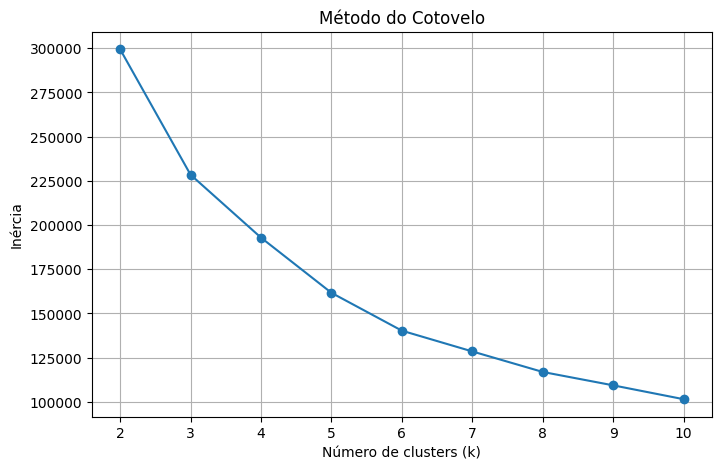

In [29]:
inercia = []
ks = range(2, 11)
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_teste)
    inercia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(ks, inercia, marker='o')
plt.title('Método do Cotovelo')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inércia')
plt.grid(True)
plt.show()

### 8.2. Avaliação com Silhouette Score

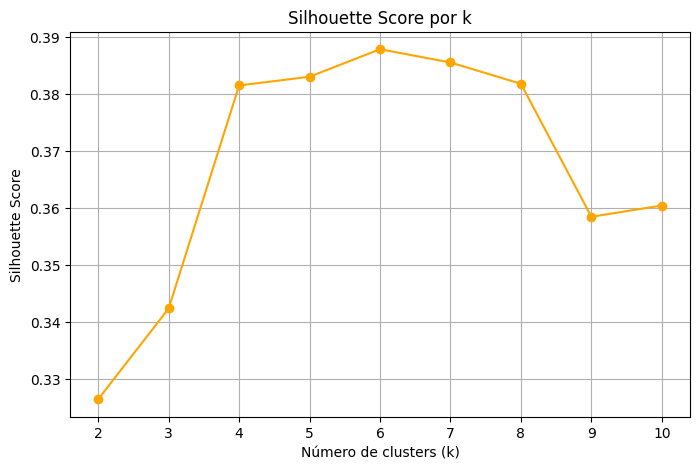

In [30]:
silhouettes = []
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_teste)
    score = silhouette_score(df_teste, labels)
    silhouettes.append(score)

plt.figure(figsize=(8, 5))
plt.plot(ks, silhouettes, marker='o', color='orange')
plt.title('Silhouette Score por k')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [31]:
df_teste.head()

,remuneracao_zscore,nivel_hierarquico,tempo_experiencia_anos,quantidade_experiencias,nivel_educacional,experiencia_sap,categoria_profissional_Consultoria / Projetos,categoria_profissional_Indefinido,categoria_profissional_Jurídico,categoria_profissional_Logística / Suprimentos,categoria_profissional_Tecnologia da Informação,categoria_profissional_outros,tem_remuneracao_zscore,tem_tempo_experiencia_anos,tem_quantidade_experiencias
0,-0.047320,0,-0.630259,1.598060,3,1,0,0,1,0,0,0,1,1,1
1,-0.017370,2,-0.630259,-0.424810,3,0,1,0,0,0,0,0,1,1,1
2,0.012500,6,-0.114530,0.839484,3,1,0,0,0,0,0,1,1,1,1
3,-0.029981,0,-0.011385,1.092342,3,0,0,0,0,1,0,0,1,1,1
4,-0.047320,0,0.504344,0.080907,3,0,0,0,1,0,0,0,1,1,1


### 8.3. Execução do KMeans com k=4

In [32]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_teste['cluster'] = kmeans.fit_predict(df_teste)

### 8.4. Análise Descritiva dos Clusters

In [33]:
# Médias por cluster
medias = df_teste.groupby('cluster').mean(numeric_only=True)

# Proporções de flags
flags = [col for col in df_teste.columns if col.startswith('tem_')]
proporcoes = df_teste[flags + ['cluster']].groupby('cluster').mean()

# Tamanho de cada cluster
tamanho = df_teste['cluster'].value_counts().sort_index()

display(medias)
display(proporcoes)
display(tamanho)

,remuneracao_zscore,nivel_hierarquico,tempo_experiencia_anos,quantidade_experiencias,nivel_educacional,experiencia_sap,categoria_profissional_Consultoria / Projetos,categoria_profissional_Indefinido,categoria_profissional_Jurídico,categoria_profissional_Logística / Suprimentos,categoria_profissional_Tecnologia da Informação,categoria_profissional_outros,tem_remuneracao_zscore,tem_tempo_experiencia_anos,tem_quantidade_experiencias
cluster,,,,,,,,,,,,,,,
0,-0.042661,3.257768,-0.111403,-0.312934,0.005787,0.069568,0.370738,0.027173,0.026922,0.049314,0.384954,0.086803,1.0,1.0,1.0
1,-0.005095,0.000000,0.086403,0.230838,3.150894,0.305949,0.033292,0.031520,0.657367,0.042232,0.143573,0.075832,1.0,1.0,1.0
2,-0.046267,0.000000,-0.061500,-0.139762,0.009125,0.143231,0.021990,0.065894,0.467240,0.138295,0.193867,0.097906,1.0,1.0,1.0
3,0.125053,3.109686,0.071653,0.166213,3.241847,0.290094,0.340906,0.018566,0.008184,0.042018,0.407597,0.124832,1.0,1.0,1.0


,tem_remuneracao_zscore,tem_tempo_experiencia_anos,tem_quantidade_experiencias
cluster,,,
0,1.0,1.0,1.0
1,1.0,1.0,1.0
2,1.0,1.0,1.0
3,1.0,1.0,1.0


0     7949
1    12976
2    13370
3     8187
Name: cluster, dtype: int64

# 09_Treina_e_salva_modelo

In [34]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(df)

In [35]:
# === 3. Salvar colunas utilizadas no input do modelo ===
colunas_usadas = df.drop(columns=['cluster']).columns.tolist()

In [36]:
# === 4. Definir diretório de saída ===
caminho_saida = r"C:\Users\pedro\Documents\Área de Trabalho\tech_challenge_5\03_modelos"
os.makedirs(caminho_saida, exist_ok=True)

In [37]:
# === 5. Salvar arquivos ===
joblib.dump(kmeans, os.path.join(caminho_saida, "modelo_kmeans.joblib"))
joblib.dump(colunas_usadas, os.path.join(caminho_saida, "colunas_usadas.joblib"))
df.to_parquet(os.path.join(caminho_saida, "04_clusterizados.parquet"), index=False)


# Variáveis contínuas usadas no modelo
variaveis_continuas = ['remuneracao_zscore', 'tempo_experiencia_anos', 'quantidade_experiencias']

# Treinar o scaler
scaler = StandardScaler()
scaler.fit(df[variaveis_continuas])

# Salvar o scaler
joblib.dump(scaler,os.path.join(caminho_saida,"scaler.joblib"))

print("✅ Modelo treinado e arquivos salvos em:")
print(caminho_saida)

✅ Modelo treinado e arquivos salvos em:
C:\Users\pedro\Documents\Área de Trabalho\tech_challenge_5\03_modelos
